In [1]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df = pd.read_csv("../Data/processed_data/all_final_for_model.csv")
X, y = df.drop(['fare_to_predict'], axis=1), df.fare_to_predict

In [5]:
model_params = {
    'linear_regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'decision_tree_regression': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [5, 10, 20, 30]
        }
    },
    'gradient_boosting_regression': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5]
        }
    },
    'random_forest_regression': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [10, 50, 100],
            'max_depth': [5, 10, 20, 30]
        }
    }
}

In [ ]:
scores = []

for i, (model_name, mp) in enumerate(model_params.items()):
    clf = RandomizedSearchCV(mp['model'], mp['params'], cv=3, return_train_score=False, n_iter=5)
    clf.fit(X, y)
    joblib.dump(clf.best_estimator_, f"trained_models/{model_name}_balanced_price.pkl")
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])

C:\Users\bhavy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\bhavy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [8]:
accuracies_dt = {'no-fare-analysis, no-dist-dur': .4589, 'no-fare-analysis, precomp-dist-dur':
    .9392, 'fare-analysed, precomp-dist-dur': .9882, 'under-sampling': .993, 'over-sampling': .9958,
                 'price-balanced': .9966}

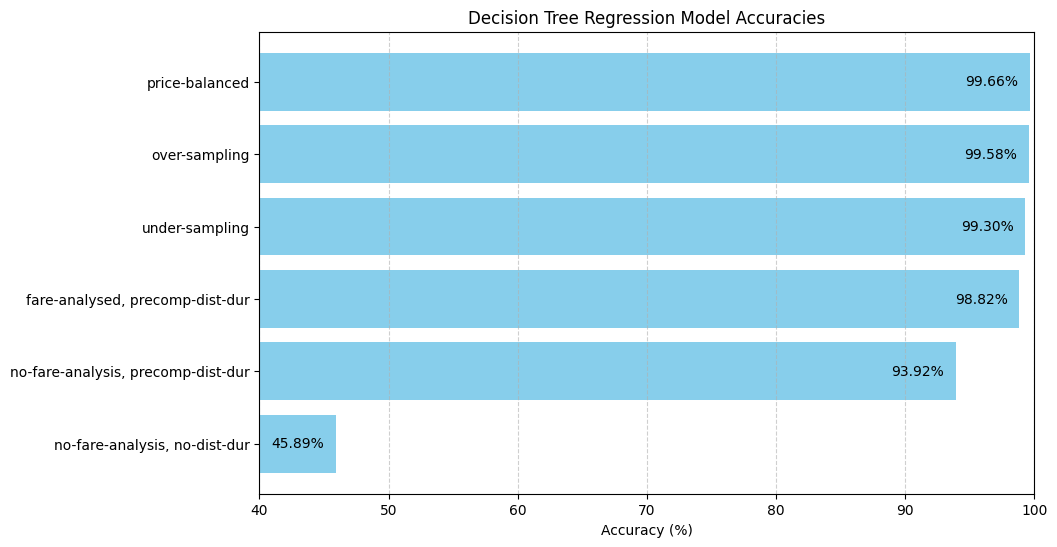

In [14]:
plt.figure(figsize=(10, 6))
bars = plt.barh(list(accuracies_dt.keys()), pd.Series(accuracies_dt.values())*100, color='skyblue')
plt.xlabel('Accuracy (%)')
plt.title('Decision Tree Regression Model Accuracies')
plt.xlim(40, 100)  # Set the x-axis limits for better visualization
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Display the accuracy values on the bars with a small offset
for bar, acc in zip(bars, pd.Series(accuracies_dt.values())*100):
    plt.text(bar.get_width() - 5, bar.get_y() + bar.get_height()/2, f'{acc:.2f}%', color='black', va='center')


In [62]:
# under sampling

class_codes = ['1A', '2A', '3A', 'CC', 'SL', '2S']
mn = len(X)
for cc in class_codes:
    mn = min(mn, X[cc].sum())

X_balanced = pd.DataFrame(columns=X.columns)
for cc in class_codes:
    sampled = X[X[cc]].sample(mn)
    X_balanced = pd.concat([X_balanced, sampled])

X_balanced = X_balanced.sample(len(X_balanced))
y_balanced = y.iloc[X_balanced.index]

# Linear regression - .882
# Decision Tree - .993

C:\Users\bhavy\AppData\Local\Temp\ipykernel_13604\2188470456.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_balanced = pd.concat([X_balanced, sampled])


In [60]:
# over sampling

class_codes = ['1A', '2A', '3A', 'CC', 'SL', '2S']
mx = 0
for cc in class_codes:
    mx = max(mx, X[cc].sum())

X_oversamp = pd.DataFrame(columns=X.columns)
for cc in class_codes:
    sampled = X[X[cc]].sample(mx, replace=True)
    X_oversamp = pd.concat([X_oversamp, sampled])

X_oversamp = X_oversamp.sample(len(X_oversamp))
y_oversamp = y.iloc[X_oversamp.index]

# Linear regression - .881
# Decision Tree - .9958

C:\Users\bhavy\AppData\Local\Temp\ipykernel_13604\3999557106.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_oversamp = pd.concat([X_oversamp, sampled])


C:\Users\bhavy\AppData\Local\Temp\ipykernel_10076\2334174687.py:10: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_balanced_price = pd.concat([y_balanced_price, y_sampled])


Text(0.5, 1.0, 'Histogram of prices to predict')

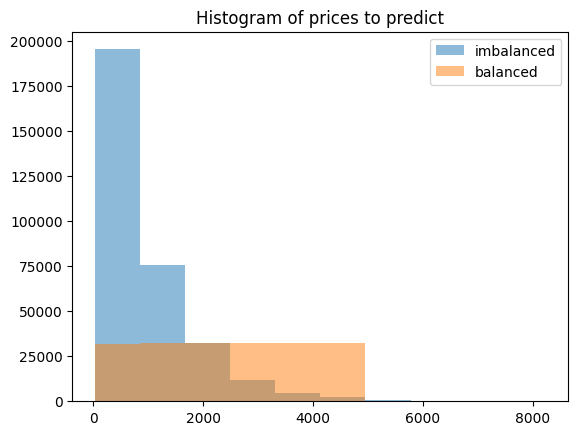

In [4]:
# sampling by price

counts, prices, _ = plt.hist(y, bins=10, alpha=.5, label='imbalanced')
n_samples = int(counts[2])

y_balanced_price = pd.Series()
for i in range(6):
    y_filt = y[(y>=prices[i]) & (y<prices[i+1])]
    y_sampled = y_filt.sample(n_samples, replace=True)
    y_balanced_price = pd.concat([y_balanced_price, y_sampled])

y_balanced_price = y_balanced_price.sample(len(y_balanced_price))
X_balanced_price = X.iloc[y_balanced_price.index]

plt.hist(y_balanced_price, bins=6, alpha=.5, label='balanced')
plt.legend()
plt.title("Histogram of prices to predict")

# Linear regression - .9298
# Decision Tree - .9967